In [1]:
# %tensorflow_version 2.x

import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
TRAIN_DATA_URL = "https://drive.google.com/uc?authuser=0&id=11uwGt8fNyHm5VJbmZU6BVhJja7gjQZVQ&export=download"
TEST_DATA_URL = "https://drive.google.com/uc?authuser=0&id=1oTfHdPxVShJOpJ8wbCP0VmymyE9m5iOf&export=download"

train_data_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_data_path = tf.keras.utils.get_file("test.csv", TEST_DATA_URL)

In [3]:
train_data_path = 'train.csv'
test_data_path = 'test.csv'

In [4]:
column_names = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff','11~12_takeoff', '18~20_ride']

train_raw = pd.read_csv(train_data_path, usecols=column_names,
                          na_values='?', skipinitialspace=True)

test_raw = pd.read_csv(test_data_path, usecols=column_names[:-1],
                       na_values='?', skipinitialspace=True)

In [5]:
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

def make_dataset(df, grid_size):
    dataset = df.copy()
    # 평일, 주말, 휴일 feature 추가
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['date_feature'] = dataset['date'].dt.weekday
    dataset.loc[dataset['date_feature'] < 5, 'date_feature'] = 0 # 0 => 평일
    dataset.loc[dataset['date_feature'] >= 5, 'date_feature'] = 1 # 1 => 주말
    
    holidays = pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14', 
                           '2019-10-03', '2019-10-09'])
    dataset.loc[dataset['date'].isin(holidays), 'date_feature'] = 2 # 2 => 휴일
    
    # 시내, 시외
    dataset['in_out'] = dataset['in_out'].map({'시내': 0, '시외': 1})
    
    # grid index -> one hot encoding
    lon = np.linspace(train_raw['longitude'].min(), train_raw['longitude'].max(), grid_size)
    lat = np.linspace(train_raw['latitude'].min(), train_raw['latitude'].max(), grid_size)
    
    dataset['grid_lon'] = dataset['longitude'].map(lambda x: geo_idx(x, lon))
    dataset['grid_lat'] = dataset['latitude'].map(lambda x: geo_idx(x, lat))
    
    dataset = pd.get_dummies(dataset, columns=['grid_lon', 'grid_lat'])
    dataset.drop(['latitude', 'longitude', 'date'], 1, inplace=True)
    
    # datetime 2시간 간격으로 합치기
    dataset['68a'] = dataset.pop('6~7_ride') + dataset.pop('7~8_ride')
    dataset['810a'] = dataset.pop('8~9_ride') + dataset.pop('9~10_ride')
    dataset['1012a'] = dataset.pop('10~11_ride') + dataset.pop('11~12_ride')
    
    dataset['68b'] = dataset.pop('6~7_takeoff') + dataset.pop('7~8_takeoff')
    dataset['810b'] = dataset.pop('8~9_takeoff') + dataset.pop('9~10_takeoff')
    dataset['1012b'] = dataset.pop('10~11_takeoff') + dataset.pop('11~12_takeoff')
    
    return dataset

In [6]:
train_120 = make_dataset(train_raw, 120)
train_120_labels = train_120.pop('18~20_ride')
test_120 = make_dataset(test_raw, 120)
train_120.head()

,in_out,date_feature,grid_lon_0,grid_lon_1,grid_lon_2,grid_lon_3,grid_lon_4,grid_lon_5,grid_lon_6,grid_lon_7,...,grid_lat_116,grid_lat_117,grid_lat_118,grid_lat_119,68a,810a,1012a,68b,810b,1012b
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,7.0,8.0,0.0,0.0,0.0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,5.0,6.0,11.0,0.0,0.0,0.0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2.0,2.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,17.0,32.0,30.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
set(train_120.columns) - set(test_120.columns)

set()

In [8]:
set(test_120.columns) - set(test_120.columns)

set()

In [9]:
numeric_columns = [
'68a', '810a', '1012a', '68b', '810b',
       '1012b'
]

categorical_columns = train_120.columns.difference(numeric_columns)

train_stats = train_120.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
68a,415423.0,1.135592,2.863275,0.0,0.0,0.0,1.0,114.0
810a,415423.0,1.457825,3.716359,0.0,0.0,0.0,1.0,181.0
1012a,415423.0,1.179010,3.361951,0.0,0.0,0.0,1.0,174.0
68b,415423.0,0.457741,1.533075,0.0,0.0,0.0,0.0,85.0
810b,415423.0,0.947403,2.672530,0.0,0.0,0.0,1.0,86.0
1012b,415423.0,0.810875,2.509226,0.0,0.0,0.0,1.0,108.0


In [10]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_120[numeric_columns])
normed_train_data[categorical_columns] = train_120[categorical_columns]
normed_test_data = norm(test_120[numeric_columns])
normed_test_data[categorical_columns] = test_120[categorical_columns]


normed_train_data= normed_train_data.apply(lambda x: np.log(x+1))
normed_test_data= normed_test_data.apply(lambda x: np.log(x+1))

In [11]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

In [12]:
SUB_MISSION_URL = "https://drive.google.com/a/dacon.io/uc?authuser=0&id=1jti3rkMN-Tb_WLOIeGVVFDYd_rfE9TFe&export=download"
submission_path = tf.keras.utils.get_file("submission_sample.csv", SUB_MISSION_URL)

In [13]:
submission_path = 'submission_sample.csv'

In [14]:
def make_submission(model, train_data, train_labels, test_data):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    EPOCHS = 1000
    history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                        validation_split=0.2, verbose=2, callbacks=[early_stop])

    plot_history(history)

    predictions = model.predict(test_data)

    submission = pd.read_csv(submission_path)
    submission['18~20_ride'] = predictions
    
    return submission

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 4s - loss: 13.8561 - mae: 1.2677 - mse: 13.8561 - val_loss: 8.4562 - val_mae: 1.1127 - val_mse: 8.4562
Epoch 2/1000
332338/332338 - 3s - loss: 10.4962 - mae: 1.1745 - mse: 10.4962 - val_loss: 7.6919 - val_mae: 1.0983 - val_mse: 7.6919
Epoch 3/1000
332338/332338 - 3s - loss: 9.7512 - mae: 1.1443 - mse: 9.7512 - val_loss: 7.7005 - val_mae: 1.0936 - val_mse: 7.7005
Epoch 4/1000
332338/332338 - 3s - loss: 9.4295 - mae: 1.1336 - mse: 9.4295 - val_loss: 7.2701 - val_mae: 1.0806 - val_mse: 7.2701
Epoch 5/1000
332338/332338 - 3s - loss: 9.1768 - mae: 1.1216 - mse: 9.1768 - val_loss: 7.3117 - val_mae: 1.0646 - val_mse: 7.3117
Epoch 6/1000
332338/332338 - 3s - loss: 8.9271 - mae: 1.1173 - mse: 8.9271 - val_loss: 7.1417 - val_mae: 1.0040 - val_mse: 7.1417
Epoch 7/1000
332338/332338 - 3s - loss: 8.8065 - mae: 1.1089 - mse: 8.8065 - val_loss: 6.8838 - val_mae: 1.0131 - val_mse: 6.8838
Epoch 8/1000
332338/332338 - 3s - l

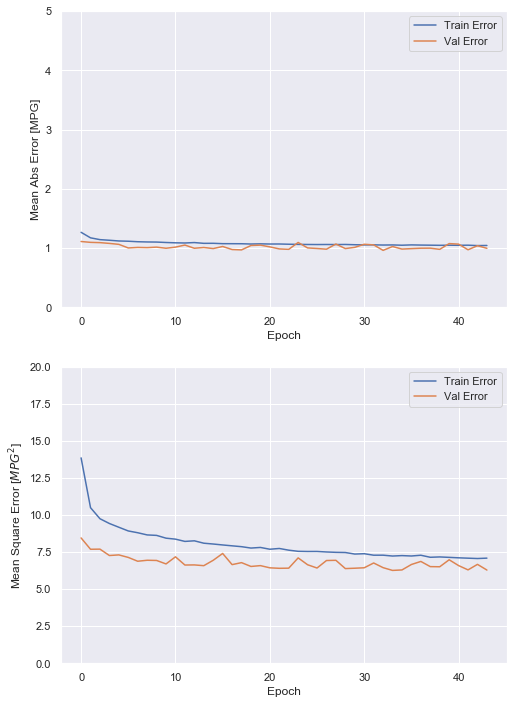

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission1 = make_submission(model, normed_train_data, train_120_labels, normed_test_data)

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 3s - loss: 13.8704 - mae: 1.2648 - mse: 13.8704 - val_loss: 8.6045 - val_mae: 1.2112 - val_mse: 8.6045
Epoch 2/1000
332338/332338 - 3s - loss: 10.7641 - mae: 1.1860 - mse: 10.7641 - val_loss: 7.7508 - val_mae: 1.0956 - val_mse: 7.7508
Epoch 3/1000
332338/332338 - 3s - loss: 10.1449 - mae: 1.1622 - mse: 10.1449 - val_loss: 7.5152 - val_mae: 1.0827 - val_mse: 7.5152
Epoch 4/1000
332338/332338 - 3s - loss: 9.8065 - mae: 1.1531 - mse: 9.8065 - val_loss: 7.4980 - val_mae: 1.0322 - val_mse: 7.4980
Epoch 5/1000
332338/332338 - 3s - loss: 9.4940 - mae: 1.1396 - mse: 9.4940 - val_loss: 7.3616 - val_mae: 1.1098 - val_mse: 7.3616
Epoch 6/1000
332338/332338 - 3s - loss: 9.3328 - mae: 1.1323 - mse: 9.3328 - val_loss: 7.3085 - val_mae: 1.0216 - val_mse: 7.3085
Epoch 7/1000
332338/332338 - 3s - loss: 9.1634 - mae: 1.1266 - mse: 9.1634 - val_loss: 7.2307 - val_mae: 1.0468 - val_mse: 7.2307
Epoch 8/1000
332338/332338 - 3s -

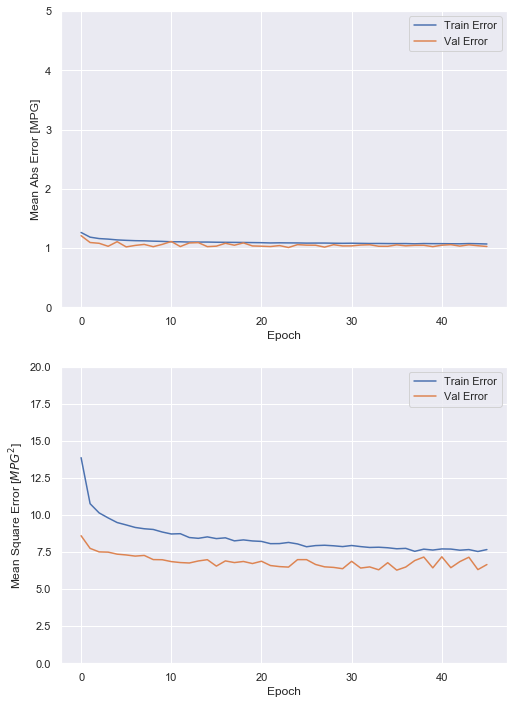

In [16]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission2 = make_submission(model, normed_train_data, train_120_labels, normed_test_data)

In [17]:
train_80 = make_dataset(train_raw, 80)
train_80_labels = train_80.pop('18~20_ride')
test_80 = make_dataset(test_raw, 80)

categorical_columns = train_80.columns.difference(numeric_columns)

train_stats = train_80.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T

normed_train_data = norm(train_80[numeric_columns])
normed_train_data[categorical_columns] = train_80[categorical_columns]
normed_test_data = norm(test_80[numeric_columns])
normed_test_data[categorical_columns] = test_80[categorical_columns]

normed_train_data= normed_train_data.apply(lambda x: np.log(x+1))
normed_test_data= normed_test_data.apply(lambda x: np.log(x+1))

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 2s - loss: 13.5077 - mae: 1.2662 - mse: 13.5077 - val_loss: 8.3743 - val_mae: 1.0707 - val_mse: 8.3743
Epoch 2/1000
332338/332338 - 2s - loss: 10.7221 - mae: 1.1759 - mse: 10.7221 - val_loss: 7.8186 - val_mae: 1.0743 - val_mse: 7.8186
Epoch 3/1000
332338/332338 - 2s - loss: 10.0576 - mae: 1.1555 - mse: 10.0576 - val_loss: 8.5542 - val_mae: 1.1094 - val_mse: 8.5542
Epoch 4/1000
332338/332338 - 2s - loss: 9.7033 - mae: 1.1447 - mse: 9.7033 - val_loss: 7.6768 - val_mae: 1.0772 - val_mse: 7.6768
Epoch 5/1000
332338/332338 - 2s - loss: 9.5236 - mae: 1.1422 - mse: 9.5236 - val_loss: 7.6590 - val_mae: 1.0550 - val_mse: 7.6590
Epoch 6/1000
332338/332338 - 2s - loss: 9.3185 - mae: 1.1367 - mse: 9.3185 - val_loss: 7.8059 - val_mae: 1.0342 - val_mse: 7.8059
Epoch 7/1000
332338/332338 - 2s - loss: 9.1696 - mae: 1.1323 - mse: 9.1696 - val_loss: 7.4455 - val_mae: 1.0421 - val_mse: 7.4455
Epoch 8/1000
332338/332338 - 2s -

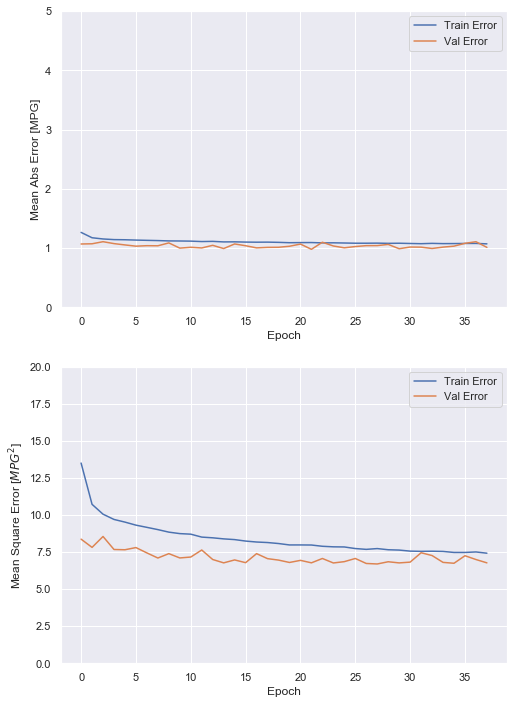

In [18]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission3 = make_submission(model, normed_train_data, train_80_labels, normed_test_data)

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 3s - loss: 14.0098 - mae: 1.2728 - mse: 14.0098 - val_loss: 8.4783 - val_mae: 1.2370 - val_mse: 8.4783
Epoch 2/1000
332338/332338 - 2s - loss: 10.9376 - mae: 1.1927 - mse: 10.9376 - val_loss: 7.8887 - val_mae: 1.1101 - val_mse: 7.8887
Epoch 3/1000
332338/332338 - 2s - loss: 10.2461 - mae: 1.1734 - mse: 10.2461 - val_loss: 7.8540 - val_mae: 1.0777 - val_mse: 7.8540
Epoch 4/1000
332338/332338 - 2s - loss: 9.9327 - mae: 1.1625 - mse: 9.9327 - val_loss: 7.7516 - val_mae: 1.0633 - val_mse: 7.7516
Epoch 5/1000
332338/332338 - 2s - loss: 9.8076 - mae: 1.1607 - mse: 9.8076 - val_loss: 7.5868 - val_mae: 1.1186 - val_mse: 7.5868
Epoch 6/1000
332338/332338 - 2s - loss: 9.5530 - mae: 1.1498 - mse: 9.5530 - val_loss: 7.4423 - val_mae: 1.0667 - val_mse: 7.4423
Epoch 7/1000
332338/332338 - 2s - loss: 9.5399 - mae: 1.1510 - mse: 9.5399 - val_loss: 7.3458 - val_mae: 1.0324 - val_mse: 7.3458
Epoch 8/1000
332338/332338 - 2s -

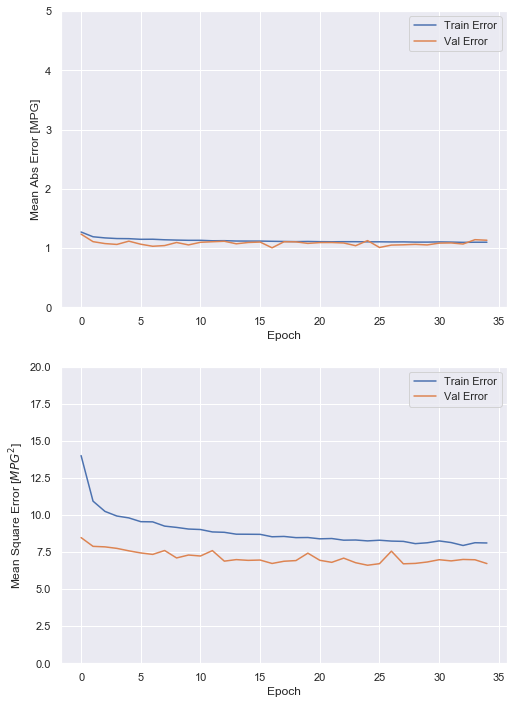

In [19]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission4 = make_submission(model, normed_train_data, train_80_labels, normed_test_data)

In [20]:
submission = (submission1 + submission2 + submission3 + submission4) *0.25
submission.to_csv('submission_0000.csv', index=False)